# ShapeRx - Medical Shape Classification

The plan 
 - [x] download a subset of the labeled vertebrae (see below)
 - [x] create (small) 2d images from many perspectives based on those 3d models (.stl)
 - [x] extract labels from filenames
 - [ ] train a model to classify based on aforementioned labels 
 - [ ] check accuracy, etc
 - [ ] tune hyperparameters
 - [ ] repeat with larger image size and more images until we are satisfied or run out of time 
 - [ ] host streamlit, textual or gradio app that serves the model someplace
 - [ ] profit


## Experimentation

### Dataset Exploration and Validation

#### Downloading

See the MSN Streamlit site for individual downloads:  https://medshapenet-ikim.streamlit.app/Download

❗ The dataset has been narrowed to vertebrae (./data/MedShapeNetDataset_vertebrae.txt) and labeled vertebrae (./data/MedShapeNetDataset_vertebrae_labeled.txt). You can fetch all (probably many gigs) with: 

```
wget --content-disposition --trust-server-names -i MedShapeNetDataset_vertebrae_labeled.txt
```

Though we probably only need a small fraction as we can generate arbitrary views with the below open3d helper functions. That is: 
1. import
2. rotate
3. save to PNG at desired size
4. repeat

This will give us as many images at whatever size we want. 

Note: Labels need to be extracted from the filenames. 

#### Sample File

In [ ]:

file7 = 'data/001313_vertebraeC1.stl'

#### Loading and Visualizing the STL File

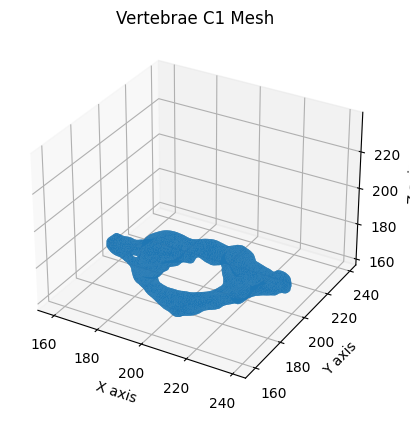

In [ ]:
import numpy as np
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot

# Create a new plot
figure = pyplot.figure()
axes = figure.add_subplot(111, projection='3d')

# Load the STL file
my_mesh = mesh.Mesh.from_file(file7)

# Add the vectors to the plot
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(my_mesh.vectors))

# Auto scale to the mesh size
scale = my_mesh.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)

# Set labels and title
axes.set_xlabel('X axis')
axes.set_ylabel('Y axis')
axes.set_zlabel('Z axis')
axes.set_title('Vertebrae C1 Mesh')

# Plot
pyplot.show()

In [ ]:
import vtk

def render_stl_with_lighting(stl_file, output_image, rotation):
    # Read the STL file
    reader = vtk.vtkSTLReader()
    reader.SetFileName(stl_file)
    reader.Update()

    # Create a mapper
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputConnection(reader.GetOutputPort())

    # Create an actor
    actor = vtk.vtkActor()
    actor.SetMapper(mapper)

    # Setting actor properties
    actor.GetProperty().SetColor(0.9, 0.9, 0.9)  # Light gray color
    actor.GetProperty().SetSpecular(0.5)
    actor.GetProperty().SetSpecularPower(20)

    # Rotate object
    actor.RotateX(rotation[0])
    actor.RotateY(rotation[1])
    actor.RotateZ(rotation[2])

    # Create renderer
    renderer = vtk.vtkRenderer()
    renderer.AddActor(actor)
    renderer.SetBackground(0.5, 0.5, 0.5)  # Grey

    # Add lighting
    light = vtk.vtkLight()
    light.SetPosition(1, 1, 1) 
    light.SetFocalPoint(0, 0, 0)  
    light.SetColor(1, 1, 1) 
    light.SetIntensity(1.0)
    renderer.AddLight(light)

    # Create render window
    render_window = vtk.vtkRenderWindow()
    render_window.AddRenderer(renderer)
    # Set Image size
    render_window.SetSize(500, 500)  

    # Render the scene
    render_window.Render()

    # Reset camera to fit the entire object
    renderer.ResetCamera()

    # Create a window-to-image filter
    w2i = vtk.vtkWindowToImageFilter()
    w2i.SetInput(render_window)
    w2i.Update()

    # Create a PNG writer
    writer = vtk.vtkPNGWriter()
    writer.SetFileName(output_image)
    writer.SetInputConnection(w2i.GetOutputPort())
    writer.Write()

    print(f"Image saved as {output_image}")



In [ ]:
# Usage
stl_file = file7
# Set the rotations
rotations = [
    (0, 0, 0),      # Default view
    (90, 0, 0),     # Top view
    (0, 90, 0),     # Side view
    (0, 0, 90),     # Front view
    (45, 45, 0),    # Isometric view
    (30, 60, 15),   # Custom angle
]

# Render and save images for each rotation
for i, rotation in enumerate(rotations):
    output_image = f"rendered_vertebrae_rotation_{i}.png"
    render_stl_with_lighting(stl_file, output_image, rotation)

Image saved as rendered_vertebrae_rotation_0.png
Image saved as rendered_vertebrae_rotation_1.png
Image saved as rendered_vertebrae_rotation_2.png
Image saved as rendered_vertebrae_rotation_3.png
Image saved as rendered_vertebrae_rotation_4.png
Image saved as rendered_vertebrae_rotation_5.png


In [2]:
import open3d as o3d
import copy 
import numpy as np
from open3d.visualization import rendering


def get_mesh(file): 
    if file.endswith('stl'): 
        return o3d.io.read_triangle_mesh(file)
        
def draw_mesh(mesh): 
    mesh.compute_vertex_normals()
    o3d.visualization.draw_geometries([mesh], width=192, height=108)

def rotate_mesh(mesh): 
    # https://www.open3d.org/docs/latest/tutorial/geometry/transformation.html#Rotation
    mesh_r = copy.deepcopy(mesh)
    R = mesh.get_rotation_matrix_from_xyz((np.pi / 2, 0, np.pi / 4))
    mesh_r.rotate(R, center=(0, 0, 0))

    return mesh_r

def save_image(mesh, h, w, png): 
    # https://github.com/isl-org/Open3D/issues/1095
    vis = o3d.visualization.Visualizer()
    vis.create_window(visible=False, width=w, height=h)
    vis.add_geometry(mesh)
    vis.update_geometry(mesh)
    vis.poll_events()
    vis.update_renderer()
    vis.capture_screen_image(png,do_render=True)
    vis.destroy_window()


def save_image2(mesh, png):           
    # MIT license, derived from open3d 
    #https://www.open3d.org/docs/latest/tutorial/visualization/interactive_visualization.html
    
    # TODO: fix? broken rendering method, can't get the passed mesh to show up in the view

    render = rendering.OffscreenRenderer(640, 480)

    yellow = rendering.MaterialRecord()
    yellow.base_color = [1.0, 0.75, 0.0, 1.0]
    yellow.shader = "defaultLit"

    #mesh.compute_triangle_normals()
    mesh.compute_vertex_normals()

    render.scene.add_geometry("mesh", mesh, yellow)
    render.setup_camera(60.0, [0, 0, 0], [0, 10, 0], [0, 0, 1])
    render.scene.scene.set_sun_light([0.707, 0.0, -.707], [1.0, 1.0, 1.0],75000)
    render.scene.scene.enable_sun_light(True)
    render.scene.show_axes(False)

    img = render.render_to_image()
    o3d.io.write_image(png, img, 9)
    
def save_image3(mesh, png): 

    # TODO: fix? also broken, the add geometry call isn't doing it... similar problem to save_image2

    green = rendering.MaterialRecord()
    green.base_color = [0.0, 0.5, 0.0, 1.0]
    green.shader = "defaultLit"

    w, h = 640, 480
    render = rendering.OffscreenRenderer(w, h)    

    #render.scene.add_model("mesh", mesh)
    render.scene.add_geometry("mesh", mesh, green)

    render.scene.scene.set_sun_light([-1, -1, -1], [1.0, 1.0, 1.0], 100000)
    render.scene.scene.enable_sun_light(True)
    render.scene.show_axes(False)

    aspect = h/w
    s = 3

    render.scene.camera.set_projection(rendering.Camera.Projection.Ortho,-s, s, -s*aspect, s*aspect, 0.1, 200)
    render.scene.camera.look_at([0, 0, 0], [100, 100, 100], [0, 0, 1])

    img = render.render_to_image()
    o3d.io.write_image(png, img)



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [208]:
!ls file2

13587.54s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


ls: cannot access 'file2': No such file or directory


In [ ]:
m = get_mesh(file7)

# pops a dialog, BOLO - ESC to clear
draw_mesh(m)

In [118]:
m2 = rotate_mesh(m)

# pops a dialog, BOLO - ESC to clear
draw_mesh(m2)

[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.


In [119]:
save_image(m, h=128, w=128, png='m1.png')
save_image(m2, h=64, w=64, png='m2.png')

[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.
[Open3D WARNING] The number of points is 0 when creating axis-aligned bounding box.


#### Visualize w/ numpy-stl

https://github.com/wolph/numpy-stl

In [120]:
import numpy as np
from stl import mesh

In [121]:
mesh2 = mesh.Mesh.from_file(file5)

FileNotFoundError: [Errno 2] No such file or directory: 'data/000007_vertebrae.stl'

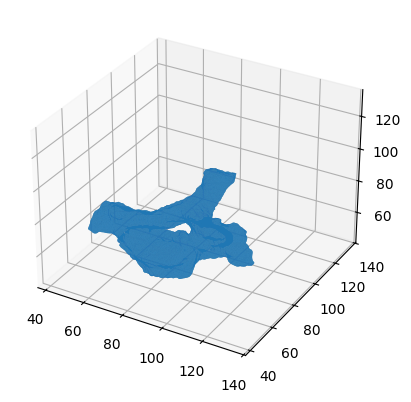

In [ ]:
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot

# Create a new plot
figure = pyplot.figure()
axes = figure.add_subplot(projection='3d')

# Add the vectors to the plot
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh2.vectors))

# Auto scale to the mesh size
scale = mesh2.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)

# Show the plot to the screen
pyplot.show()

#### Visualize w/ MSN utilities

The jupyter notebook provided by the MedShapeNet dude (https://colab.research.google.com/github/Jianningli/medshapenet-feedback/blob/main/pip_install_MedShapeNetCore/getting_started.ipynb) suggest we can load and manipulate the datasets with the python library. Let's find out. 

In [30]:
from MedShapeNetCore.MedShapeNetCore import MyDict,MSNLoader,MSNVisualizer,MSNSaver,MSNTransformer

ModuleNotFoundError: No module named 'MedShapeNetCore'

In [5]:
msn_loader=MSNLoader()
msn_vis=MSNVisualizer()
msn_saver=MSNSaver()
msn_transformer=MSNTransformer()

In [6]:
data = msn_loader.load('AutoImplantCraniotomy') 

current dataset: ./medshapenetcore_npz/medshapenetcore_AutoImplantCraniotomy.npz
available keys in the dataset: ['mask']


In [8]:
volume = data['mask']
points = data['point']
#mesh_vertice = data['mesh']['vertices']
mesh_face = data['mesh']['faces']

In [11]:
# data ['mesh'] has no 'vertices' key... 
data['mesh']

MyDict([('faces', MyDict())])

In [9]:
len(volume) 

11

This is wrong?

In [29]:
#print(points.shape) -> doesn't work
#print(volume.shape) -> doesn't work
#print(points.shape) -> doesn't work
#print(mesh_vertice.shape) -> doesn't work
print(mesh_face.shape)
#print(mesh_vertice[0].shape) -> doesn't work

NameError: name 'mesh_face' is not defined

This should also work, per the notebook. 

I guess they never tested the python package with the cranial data? :(

#### Visualize w/ macOS


It turns out macOS has a native STL viewer. Just double click the file to review... 

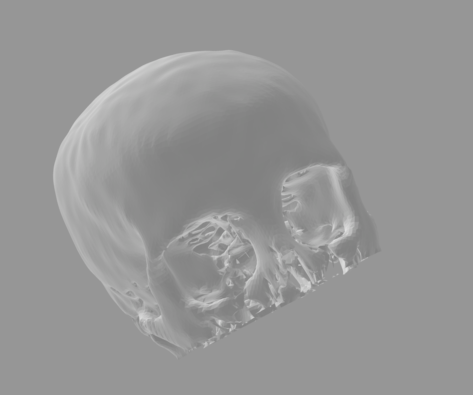

## Dataset Generation 

In [1]:
import os 
import pandas as pd
import re 

# Create a dataframe that represents everything we've got on disk

def decode_label(filename:str) -> str:
    match = re.search(".*vertebrae_?([A-Z][0-9]).*.stl", filename)
    if match: 
        return match.group(1)
                 
def load_mesh_metadata(dir:str) -> pd.DataFrame: 
    metadata = pd.DataFrame(columns=['filename', 'label'])
    for i, file in enumerate(os.listdir(dir)): 
        if file.endswith('stl'): 
            metadata.loc[i] = {'filename': file, 'label': decode_label(file)}

    return metadata


In [2]:
df = load_mesh_metadata('data/')

In [3]:
df.head()

,filename,label
0,s0197_vertebrae_T7.nii.g_1.stl,T7
1,s0333_vertebrae_C7.nii.g_1.stl,C7
2,061481_vertebraeT7.stl,T7
3,060478_vertebraeL5.stl,L5
4,024073_vertebraeT4.stl,T4


In [4]:
groups = df.groupby(by='label')

In [5]:
s = groups.size()

In [6]:
g_df = s.reset_index()
g_df.columns = ['label', 'count']

In [7]:
g_df.head()

,label,count
0,C1,332
1,C2,331
2,C3,329
3,C4,332
4,C5,348


In [8]:
def sample_meshes(df, n=10):
    
    samples = pd.DataFrame()
    for _class in df['label'].unique(): 
        class_samples = df[df['label'] == _class].sample(n=n)
        
        samples = pd.concat([samples, class_samples])
    return samples


In [9]:
df2 = sample_meshes(df)

In [10]:
df2.head()

,filename,label
2533,016793_vertebraeT7.stl,T7
8394,088669_vertebraeT7.stl,T7
3755,051100_vertebraeT7.stl,T7
5045,072347_vertebraeT7.stl,T7
6287,s0331_vertebrae_T7.nii.g_1.stl,T7


In [11]:
g_df2 = df2.groupby(by='label').count()
g_df2

,filename
label,
C1,10
C2,10
C3,10
C4,10
C5,10
C6,10
C7,10
L1,10
L2,10


In [80]:
# Render to images
df2.head()

,filename,label
2533,016793_vertebraeT7.stl,T7
8394,088669_vertebraeT7.stl,T7
3755,051100_vertebraeT7.stl,T7
5045,072347_vertebraeT7.stl,T7
6287,s0331_vertebrae_T7.nii.g_1.stl,T7


In [74]:
bad_file = 'data/052913_vertebraeC3.stl'
bad_file2 = '052913_vertebraeC3.stl'
good_file = 'data/s0326_vertebrae_C3.nii.g_1.stl'
good_file2 = 's0326_vertebrae_C3.nii.g_1.stl'

In [75]:
good = get_mesh(good_file)


In [76]:
len(good.vertices)

18180

In [77]:
bad = get_mesh(bad_file)

[Open3D WARNING] Unable to load file data/052913_vertebraeC3.stl with ASSIMP: Failed to determine STL storage representation for data/052913_vertebraeC3.stl.


In [78]:
len(bad.vertices) 

0

In [79]:
good2 = get_mesh(bad_file2)

[Open3D WARNING] Unable to load file 052913_vertebraeC3.stl with ASSIMP: Failed to determine STL storage representation for 052913_vertebraeC3.stl.


In [83]:
size_pixels = 32
angle = 15

In [518]:
# TODO: decide if these should start at 0 ... I suppose the network will learn either way
class_map = {
    'L1' : 1, 
    'L2' : 2, 
    'L3' : 3, 
    'L4' : 4, 
    'L5' : 5, 
    'T1' : 6, 
    'T2' : 7, 
    'T3' : 8, 
    'T4' : 9, 
    'T5' : 10, 
    'T6' : 11, 
    'T7' : 12, 
    'T8' : 13, 
    'T9' : 14, 
    'T10' : 15, 
    'T11' : 16, 
    'T12' : 17, 
    'C1' : 18, 
    'C2' : 19, 
    'C3' : 20, 
    'C4' : 21, 
    'C5' : 22, 
    'C6' : 23, 
    'C7' : 24, 
}

def get_class_index(name:str): 
    name = name.upper()
    if name in class_map: 
        return class_map[name]
    
def get_class_label(index:int):
    for key, value in class_map.items():
        if index == value: 
            return key 

In [514]:
get_class_index('L7')

In [517]:
get_class_label(0)

In [554]:
def generate_images(sdf, dir, size, angle):
    
    df = pd.DataFrame(columns=['source', 'file', 'label'])

    insert_at = 0 
    
    for row in sdf.itertuples(): 
        id = row[0]
        file = row[1]
        label = row[2]        

        sample = get_mesh(os.path.join('data',file))
        if len(sample.vertices) > 0: 
            X = range(0, 360, angle)
            Y = range(0, 360, angle)
            Z = range(0, 360, angle)
            for x in X: 
                for y in Y: 
                    for z in Z: 
                        rotated = rotate_mesh(sample, x, y, z)
                        
                        # TODO: save these generated images in their own experiment folder so we can be screwing 
                        # around with this while model training is happening
                        image_file = f"{id}-{label}-{size}-{x}-{y}-{z}.png"
                        path = os.path.join(dir, image_file)

                        print(f"writing {path}...")
                        save_image(mesh=rotated, 
                            h=size_pixels, 
                            w=size_pixels, 
                            png=path)
                        
                        r = { 'source': file, 'file' : image_file, 'label': get_class_index(label),}
                        print(r)
                        df.loc[insert_at] = r
                        
                        insert_at += 1
                         
        else: 
            # TODO: unclear why we can't load some of these STL files, but some appear to be missing some opening 
            # tags... perhaps a download problem. consider implementing some handling or investigating further
            pass

    return df


In [520]:
# reduce the number of samples in DF so this is easy to iterate with
train_df = df2.sample(frac=0.02)

In [521]:
train_df.head()

,filename,label
3183,019611_vertebraeT5.stl,T5
3711,096001_vertebraeC6.stl,C6
5882,022953_vertebraeT3.stl,T3
4619,068738_vertebraeL3.stl,L3


In [103]:
!mkdir experiments
!mkdir experiments/1

mkdir: cannot create directory ‘experiments’: File exists


mkdir: cannot create directory ‘experiments/1’: File exists


we need to generate some images ... but time is something we should be concerned about for this tiny run we have...
- 4 models 
- 3 axes per model
- 360/15 = 24 poses per axis

this is 4 x 24^3 = 55296 images

at least it won't be hard to hit the scale we need for transfer learning, or training a network from scratch. on the other hand, it's going to take a long time to write 55 thousand images. it took 913 minutes on my workstation - not advisable to repeat.  

⏰ the angle parameter is critical to keep low for our demonstration. image size doesn't seem to affect run time, though obviously could affect storage depending on how much we're trying to generate. suggest 45 degrees and 128 pixels (yolov8 base models all want increments of 32 so adher to that to support transfer learning option) 

at 128 pixels and 45 degree increments for 2 samples/class we have: 
 - 33 classes
 - 2 models per class
 - 360/45 = 8 orientiations per axis
  
so 33 * 2 * 8^3 = 33 * 2 * 512 = ~33K ... we might want to do a single model (15K images, 512 per class)

In [233]:
#generate_images(train_df, 'experiments/1', 32, 120)

❗ Critical issue here is the lack of lighting on the rendered images, it results in all detail other than the profile of the object being lost. We need to add the camera to the rendering function (o3d research)

In [522]:
train_df.shape

(4, 2)

In [523]:
!mkdir -p experiments/5

In [555]:
# the above 50000 images is a little heavy for testing, regenerate with a more approachable number of rows
srx_dataset = generate_images(train_df, 'experiments/5', 32, 120)

writing experiments/5/3183-T5-32-0-0-0.png...
{'source': '019611_vertebraeT5.stl', 'file': '3183-T5-32-0-0-0.png', 'label': 10}
writing experiments/5/3183-T5-32-0-0-120.png...
{'source': '019611_vertebraeT5.stl', 'file': '3183-T5-32-0-0-120.png', 'label': 10}
writing experiments/5/3183-T5-32-0-0-240.png...
{'source': '019611_vertebraeT5.stl', 'file': '3183-T5-32-0-0-240.png', 'label': 10}
writing experiments/5/3183-T5-32-0-120-0.png...
{'source': '019611_vertebraeT5.stl', 'file': '3183-T5-32-0-120-0.png', 'label': 10}
writing experiments/5/3183-T5-32-0-120-120.png...
{'source': '019611_vertebraeT5.stl', 'file': '3183-T5-32-0-120-120.png', 'label': 10}
writing experiments/5/3183-T5-32-0-120-240.png...
{'source': '019611_vertebraeT5.stl', 'file': '3183-T5-32-0-120-240.png', 'label': 10}
writing experiments/5/3183-T5-32-0-240-0.png...
{'source': '019611_vertebraeT5.stl', 'file': '3183-T5-32-0-240-0.png', 'label': 10}
writing experiments/5/3183-T5-32-0-240-120.png...
{'source': '019611_ver

## Model Training

In [526]:
classification_models = torchvision.models.list_models(module=torchvision.models)
classification_models

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'googlenet',
 'inception_v3',
 'maxvit_t',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_8gf',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext101_64x4d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'sh

### Vanilla CNN

Start with a binary classifier to get the kinks out. C6 or not C6. 

In [527]:
import torch
import torchvision 
import torchvision.transforms as transforms

In [528]:
# Look at a pytorch CNN example to understand the data format

# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

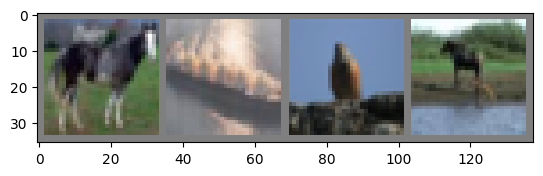

horse ship  bird  deer 


In [529]:
# And render to ensure they are loaded 

# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [530]:
batch = None
for i, b in enumerate(trainloader): 
    batch = b
    break 

In [531]:
len(batch)

2

In [532]:
# images
batch[0]

tensor([[[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 0.9686,  0.9686,  0.9686,  ...,  0.9686,  0.9686,  0.9686],
          [ 0.9686,  0.9686,  0.9686,  ...,  0.9686,  0.9686,  0.9686],
          [ 0.9686,  0.9686,  0.9686,  ...,  0.9686,  0.9686,  0.9686],
          ...,
          [ 0.9686,  0.9686,  0.9686,  ...,  0.9686,  0.9686,  0.9686],
          [ 0.9686,  0.9686,  0.9686,  ...,  0.9686,  0.9686,  0.9686],
          [ 0.9686,  0.9686,  0.9686,  ...,  0.9686,  0.9686,  0.9686]],

         [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  

In [533]:
# labels 
batch[1]

tensor([0, 5, 5, 7])

In [534]:
images[0].shape

torch.Size([3, 32, 32])

Inputs are 3-channel, 32-pixel square tensors. Let's convert our data to match for the test run. 

In [535]:
from PIL import Image, features

features.pilinfo()


--------------------------------------------------------------------
Pillow 11.1.0
Python 3.12.3 (main, Jan 17 2025, 18:03:48) [GCC 13.3.0]
--------------------------------------------------------------------
Python executable is /home/grim/projects/school/shaperx/venv/bin/python
Environment Python files loaded from /home/grim/projects/school/shaperx/venv
System Python files loaded from /usr
--------------------------------------------------------------------
Python Pillow modules loaded from /home/grim/projects/school/shaperx/venv/lib/python3.12/site-packages/PIL
Binary Pillow modules loaded from /home/grim/projects/school/shaperx/venv/lib/python3.12/site-packages/PIL
--------------------------------------------------------------------
--- PIL CORE support ok, compiled for 11.1.0
*** TKINTER support not installed
--- FREETYPE2 support ok, loaded 2.13.2
--- LITTLECMS2 support ok, loaded 2.16
--- WEBP support ok, loaded 1.5.0
--- JPEG support ok, compiled for libjpeg-turbo 3.1.0
--- OPE

In [536]:
!ls experiments/5

1340-T3-32-0-0-0.png	    5882-T3-32-0-0-120.png
1340-T3-32-0-0-120.png	    5882-T3-32-0-0-240.png
1340-T3-32-0-0-240.png	    5882-T3-32-0-120-0.png
1340-T3-32-0-120-0.png	    5882-T3-32-0-120-120.png
1340-T3-32-0-120-120.png    5882-T3-32-0-120-240.png
1340-T3-32-0-120-240.png    5882-T3-32-0-240-0.png
1340-T3-32-0-240-0.png	    5882-T3-32-0-240-120.png
1340-T3-32-0-240-120.png    5882-T3-32-0-240-240.png
1340-T3-32-0-240-240.png    5882-T3-32-120-0-0.png
1340-T3-32-120-0-0.png	    5882-T3-32-120-0-120.png
1340-T3-32-120-0-120.png    5882-T3-32-120-0-240.png
1340-T3-32-120-0-240.png    5882-T3-32-120-120-0.png
1340-T3-32-120-120-0.png    5882-T3-32-120-120-120.png
1340-T3-32-120-120-120.png  5882-T3-32-120-120-240.png
1340-T3-32-120-120-240.png  5882-T3-32-120-240-0.png
1340-T3-32-120-240-0.png    5882-T3-32-120-240-120.png
1340-T3-32-120-240-120.png  5882-T3-32-120-240-240.png
1340-T3-32-120-240-240.png  5882-T3-32-240-0-0.png
1340-T3-32-240-0-0.png	    5882-T3-32-240-0-120.png
1340-T

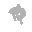

In [537]:
# PIL will accept PNGs (see above), open our image and then ues the pytorch transform to get a tensor
# We can also just call torchvision.io.read_image() ... 
img = Image.open('experiments/5/9901-C6-32-240-240-240.png')
img

In [258]:
r, g, b = img.split()

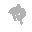

In [259]:
r

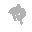

In [260]:
g

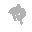

In [261]:
b

In [265]:
r.getpixel((0,0))

255

❗ we have 0-255 uint8s here it seems, make sure these are converted to floats in the range 0 - 1 during load

In [557]:
# It seems the easiest way to support these operations is by sublcassing a pytorch Dataset... urgh.
# Based on https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

class ShapeRxDataset(torch.utils.data.Dataset): 
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None): 

        # This is just a hair off the df we emit from generate_images, see above for minor transformation 
        # to achieve alignement w/ torch expectations (columns = file, label)
        self.img_labels = pd.read_csv(annotations_file)

        self.img_dir = img_dir
        self.transform = transform 
        self.target_transform = target_transform 

    def __len__(self): 
        return len(self.img_labels) 
    
    def __getitem__(self, idx): 
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        
        # This implicitly handles PNG -- wooo!
        # https://pytorch.org/vision/main/generated/torchvision.io.decode_image.html#torchvision.io.decode_image
        #image = torchvision.io.decode_image(input=img_path, mode=torchvision.io.ImageReadMode.GRAY)
        image = torchvision.io.decode_image(input=img_path)

        label = self.img_labels.iloc[idx, 1]
        if self.transform: 
            image = self.transform(image)  
        if self.target_transform: 
            label = self.target_transform(label) 
        return image, label 


In [559]:
srx_dataset.head()

,source,file,label
0,019611_vertebraeT5.stl,3183-T5-32-0-0-0.png,10
1,019611_vertebraeT5.stl,3183-T5-32-0-0-120.png,10
2,019611_vertebraeT5.stl,3183-T5-32-0-0-240.png,10
3,019611_vertebraeT5.stl,3183-T5-32-0-120-0.png,10
4,019611_vertebraeT5.stl,3183-T5-32-0-120-120.png,10


In [560]:
# write the labels to disk with pandas as a csv, they will be read by the Dataset subclass... 
# format appears to be 
#  - filename
#  - label 
# conveniently our generate function emits a df with 
#  - model file 
#  - img file
#  - label 
annotations = srx_dataset.drop(labels='source', axis='columns')
annotations.head(len(annotations))

,file,label
0,3183-T5-32-0-0-0.png,10
1,3183-T5-32-0-0-120.png,10
2,3183-T5-32-0-0-240.png,10
3,3183-T5-32-0-120-0.png,10
4,3183-T5-32-0-120-120.png,10
...,...,...
103,4619-L3-32-240-120-120.png,3
104,4619-L3-32-240-120-240.png,3
105,4619-L3-32-240-240-0.png,3
106,4619-L3-32-240-240-120.png,3


In [561]:
annotations_file = 'experiments/5/annotations.csv'
annotations.to_csv(annotations_file, index=False)

In [562]:
!cat experiments/5/annotations.csv

file,label
3183-T5-32-0-0-0.png,10
3183-T5-32-0-0-120.png,10
3183-T5-32-0-0-240.png,10
3183-T5-32-0-120-0.png,10
3183-T5-32-0-120-120.png,10
3183-T5-32-0-120-240.png,10
3183-T5-32-0-240-0.png,10
3183-T5-32-0-240-120.png,10
3183-T5-32-0-240-240.png,10
3183-T5-32-120-0-0.png,10
3183-T5-32-120-0-120.png,10
3183-T5-32-120-0-240.png,10
3183-T5-32-120-120-0.png,10
3183-T5-32-120-120-120.png,10
3183-T5-32-120-120-240.png,10
3183-T5-32-120-240-0.png,10
3183-T5-32-120-240-120.png,10
3183-T5-32-120-240-240.png,10
3183-T5-32-240-0-0.png,10
3183-T5-32-240-0-120.png,10
3183-T5-32-240-0-240.png,10
3183-T5-32-240-120-0.png,10
3183-T5-32-240-120-120.png,10
3183-T5-32-240-120-240.png,10
3183-T5-32-240-240-0.png,10
3183-T5-32-240-240-120.png,10
3183-T5-32-240-240-240.png,10
3711-C6-32-0-0-0.png,23
3711-C6-32-0-0-120.png,23
3711-C6-32-0-0-240.png,23
3711-C6-32-0-120-0.png,23
3711-C6-32-0-120-120.png,23
3711-C6-32-0-120-240.png,23
3711-C6-32-0-240-0.png,23
3711-C6-32-0-240-120.png,23
3711-C6-32-0-240-240.

In [563]:
# Our dataset class creates a uint8 tensor on load, we need to convert to float and normalize
transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float),
    ])

In [564]:
dataset = ShapeRxDataset(annotations_file, 'experiments/5', transform)

In [565]:
len(dataset)

108

In [566]:
loader = torch.utils.data.DataLoader(dataset)

In [567]:
dataiter = iter(loader)

In [568]:
image, label = next(dataiter)
image, label

(tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
 
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
 
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]]]),
 tensor([10]))

In [569]:
image.min()

tensor(0.6980)

In [570]:
image.max()

tensor(1.)

Okay, now we have a torch-compatible dataset that is emitting tensors, which are scaled and normalized by the transformation provided and that is accessible by the loader object. 

In [571]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = (img / 2 + 0.5) * 256    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

... but the iterator is returning an extra dimension for batch (). We need to squeeze() it to omit the batch dimension, then we can render it. 

In [572]:
image.numpy().shape

(1, 3, 32, 32)

In [573]:
image.squeeze().numpy().shape

(3, 32, 32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [217.34903..256.0].


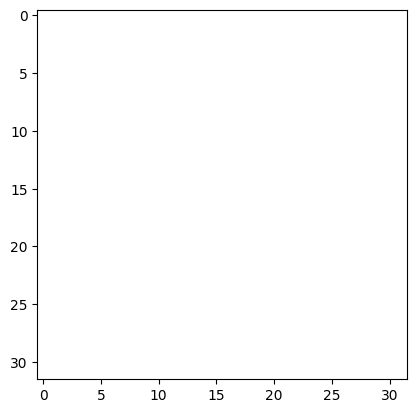

tensor([10])


In [574]:
imshow(image.squeeze())
print(label)

❗ TODO: get the above image to render to ensure we are loading correclty

In [575]:
# note the totensor operation should drive the pixel values to 0-1 float 
transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.5], std=[0.5])
    ])

In [576]:
dataset = ShapeRxDataset(annotations_file, 'experiments/5', transform=transform)
#dataset = ShapeRxDataset(annotations_file, 'experiments/5')
loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)

In [598]:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super().__init__()
        
        # in, out, kernel size
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(class_map))

    def forward(self, x):
        # 1. Convolution + pooling
        # input:       3 x 32^2 
        # conv @ 6, 5: 6 x 28^2
        # pool @ 2x2:  6 x 14^2
        x = self.pool(F.relu(self.conv1(x)))

        # 2. Convlution + pooling
        # input:       6 x 14^2 
        # conv @ 16,5: 16 x 10^2
        # pool @ 2x2:  16 x 5^2
        x = self.pool(F.relu(self.conv2(x)))

        # 3. Reshape
        # input:       16 x 5^2
        # flatten @ 1: 1 x 400
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        # 4. Fully-connecter
        # input:       1 x 400
        # linear:      1 x 120
        x = F.relu(self.fc1(x))
        
        # 5. Fully-connected 
        # input:       1 x 120
        # linear:      1 x 84
        x = F.relu(self.fc2(x))
            
        # 6. Fully-connected output 
        # input:       1 x 84
        # linear:      1 x 24 (vertebrae/classes)
        x = self.fc3(x)
        
        return x


net = Net()

In [583]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [584]:
type(loader)

torch.utils.data.dataloader.DataLoader

In [585]:
for i, data in enumerate(loader, 0):
    print(data[0].max(), data[0].min())
    break 

tensor(1.) tensor(0.3961)


In [588]:
# Adapted from PyTorch image classifier tutorial - https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 0.016
[1,    40] loss: 0.015
[2,    20] loss: 0.015
[2,    40] loss: 0.015
Finished Training


❗ TODO: probably need to normalize our inputs here so they are floats and not 0-255... see above

In [590]:
output = net(image)

In [594]:
output

tensor([[-0.0338, -0.8743, -0.8736,  3.4067, -1.0474, -0.7770, -0.8044, -0.7456,
          3.9326, -0.8288,  3.7723, -0.7206, -0.6432, -0.2598, -0.5207, -0.9175,
         -0.9331, -1.0665, -0.7689, -0.7508, -0.7480, -1.1863, -0.9056,  3.3946]],
       grad_fn=<AddmmBackward0>)

In [595]:
# Export to ONNX format
#https://pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html

torch_input = torch.randn(1, 3, 32, 32)
onnx_program = torch.onnx.dynamo_export(net, torch_input)

/home/grim/projects/school/shaperx/venv/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/grim/projects/school/shaperx/venv/lib/python3.12/site-packages/onnxscript/converter.py:823: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/home/grim/projects/school/shaperx/venv/lib/python3.12/site-packages/torch/onnx/_internal/_exporter_legacy.py:101: UserWarning: torch.onnx.dynamo_export only implements opset version 18 for now. If you need to use a different opset version, please register them with register_custom_op.
  warnings.warn(
/home/grim/projects/school/shaperx/venv/lib/python3.12/site-packages/torch/onnx/_internal/fx/onnxfunctio

In [597]:
onnx_program.save("experiments/5/model.onnx")

Netron rendering of the network: 

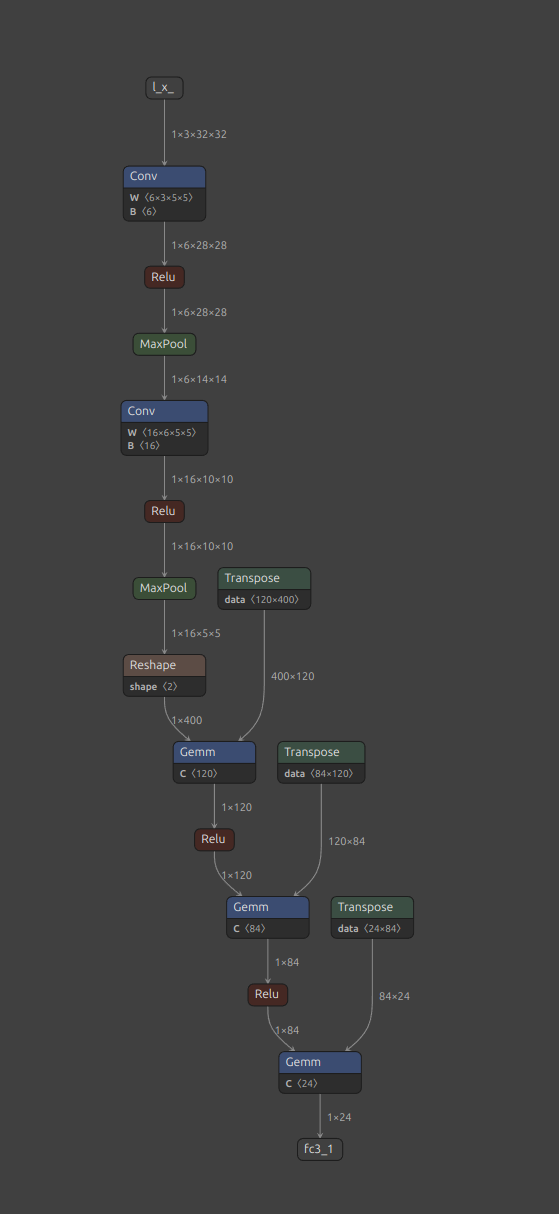

### YOLOv8 tuning

## Model Validation

## Deployment

TBD - wait to see what the computational and storage requirements are for the classification model and then use a rapid prototyping package like textual or streamlit to mock up a demo. 